In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, Normalizer,PowerTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses

import matplotlib.pyplot as plt

# Design id
#
# * 0: Non-linear front-end with ADC quantization
# * 1: Non-linear front-end without ADC quantization
# * 2: Linear front-end with ADC quantization
# * 3: Linear front-end without ADC quantization
id = 4
it = 1      # iteration

nrx = 16    # num of receiver antennas
nsnr = 31   # num of snr points
nx = 10000  # num of tx samples

## Read the data fromt the input files

In [2]:
df = pd.read_csv(r'../../datasets/rx_2/idata_'+str(it)+'.csv')
# Random tx data
x = np.char.replace(np.array(df['x'],dtype=str),'i','j').astype(np.complex)

# Channel w
w = np.array([np.char.replace(np.array(df['w_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nrx)], dtype=complex)

y_ant = np.array([np.char.replace(np.array(df['yant_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
              for isnr in range(nsnr) for irx in range(nrx) ], dtype=complex).T.reshape(nx*nsnr,nrx)

df = pd.read_csv(r'../../datasets/rx_2/odata_'+str(id+1)+'_'+str(it)+'.csv')
y_rffe = np.array([np.char.replace(np.array(df['yrffe_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
                    for isnr in range(nsnr) for irx in range(nrx)]).T.reshape(nx*nsnr,nrx)

df = pd.read_csv(r'../../datasets/rx_2/param_1_'+str(id+1)+'_'+str(it)+'.csv')
power_in = df['Pin']

# Print the shape for some of the arrays
print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')

y_ant shape: (310000, 16)
y_rffe shape: (310000, 16)


In [3]:
wx = (w*x).transpose()
wx.shape

(10000, 16)

In [4]:
wx = np.repeat(wx,[nsnr],axis=0)
wx.shape

(310000, 16)

In [5]:
# Baseline data
y_rffe = y_rffe.reshape(nx, nsnr, nrx)

# Baseline data
y_ant = y_ant.reshape(nx, nsnr, nrx)

wx = wx.reshape(nx, nsnr, nrx)

print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')
print(f'wx shape: {wx.shape}')

y_ant shape: (10000, 31, 16)
y_rffe shape: (10000, 31, 16)
wx shape: (10000, 31, 16)


In [6]:
y_ant_norm = y_ant / np.linalg.norm(y_ant,axis=0)
y_rffe_norm = y_rffe / np.linalg.norm(y_rffe,axis=0)
wx_norm = wx / np.linalg.norm(wx,axis=0)

## Define some helper functions

In [7]:
def snr(Phi):
    xh = sum(Phi.T*np.conj(w),0)/np.sum(np.abs(w)**2,0)
    a = np.mean(np.conj(xh)*x)/np.mean(np.abs(x)**2)
    d_var = np.mean(np.abs(xh - a*x)**2)
    snr_out = 10*np.log10(np.abs(a)**2/d_var)
    return snr_out

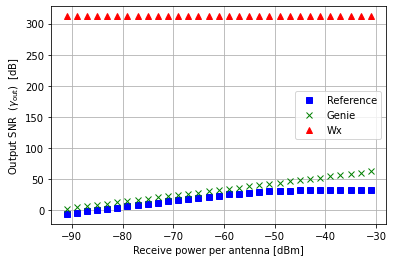

In [8]:

# Baseline data
base = y_rffe_norm

# Baseline data
gold = y_ant_norm

base_snr = np.zeros(nsnr)
gold_snr = np.zeros(nsnr)
wx_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    base_snr[isnr] = snr(base[:, isnr, :])
    gold_snr[isnr] = snr(gold[:, isnr, :])
    wx_snr[isnr] = snr(wx_norm[:, isnr, :])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, gold_snr, 'gx')
plt.plot(power_in, wx_snr, 'r^')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'Genie','Wx'])

## Prepare the training and test data

In [9]:
y_ant_norm_all = y_ant_norm.reshape(nx*nsnr,nrx)
y_rffe_norm_all = y_rffe_norm.reshape(nx*nsnr,nrx)
wx_norm_all = wx_norm.reshape(nx*nsnr,nrx)
r = np.hstack((wx_norm_all.real, wx_norm_all.imag))
X = np.hstack((y_rffe_norm_all.real, y_rffe_norm_all.imag))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, r, shuffle=True, test_size=0.1)


# scale_in = StandardScaler(with_mean=True, with_std=True).fit(x_train)
# scale_out = StandardScaler(with_mean=True, with_std=True).fit(y_train)
scale_in = PowerTransformer().fit(x_train)
scale_out = PowerTransformer().fit(y_train)

x_train = scale_in.transform(x_train)
x_test = scale_in.transform(x_test)
y_train = scale_out.transform(y_train)
y_test = scale_out.transform(y_test)

print(f'x_train shape: {x_train.shape}')

x_train shape: (279000, 32)


In [11]:
x_train[:5,:]

array([[ 0.66966653, -2.16468194,  1.99695716, -2.38137735, -1.23558562,
         2.19985465, -1.0351493 ,  2.18378712, -1.42626259, -2.37053501,
        -0.1017701 , -0.28811489, -1.98604814, -0.85406689, -2.37872139,
        -1.44006046,  2.37892184,  1.04926959, -1.40832696,  0.30126348,
         2.19220798,  1.05669967,  2.18056758,  0.87180022, -1.98770596,
         0.65393628, -2.4016006 , -2.37849132, -1.42382102, -2.16998587,
         0.09936705, -2.18630032],
       [-0.66244085,  0.67545255,  0.85456376,  0.2844232 , -0.66233016,
        -0.2660698 , -0.65329614, -0.47477854, -0.28694903,  0.10271196,
        -0.67192488, -0.85534728,  0.67138289,  0.28506404,  0.09842459,
         0.27801366, -0.28861355, -0.27584516,  0.1027852 , -0.65356971,
         0.28109507,  0.86772081,  0.09489133,  0.68173619, -0.67171511,
        -0.86975781, -0.08469933,  0.10418719, -0.47010425, -0.65057536,
        -0.84424884, -0.85751254],
       [-1.23634573, -1.41552908, -0.47996938,  1.4184

## Create and train the neural network

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear')
])
model.compile(optimizer='sgd', loss=losses.MeanSquaredError())
# model.compile(optimizer='sgd', loss=losses.CosineSimilarity(axis=1))


model.fit(x_train, y_train,
          epochs=10,
          batch_size=256,
          shuffle=True,
          validation_data=(x_test, y_test))

Epoch 1/10
1090/1090 [==============================] - 4s 3ms/step - loss: 0.7629 - val_loss: 0.5137

## Compare the output-SNR of the neural network with the baseline

In [13]:
X.shape

(310000, 32)

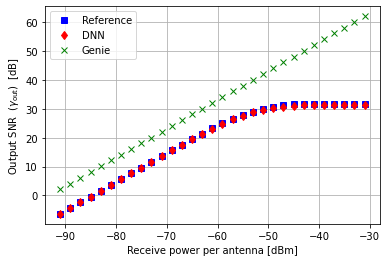

In [14]:
# Use the NN to predict the new data
pred = model(scale_in.transform(X)).numpy()

# Find the complex data
pred = pred[:, :16] + 1j * pred[:, 16:]
pred = pred.reshape(nx, nsnr, nrx)

# Baseline data
base = y_rffe.reshape(nx, nsnr, nrx)

# Baseline data
gold = y_ant.reshape(nx, nsnr, nrx)

pred_snr = np.zeros(nsnr)
base_snr = np.zeros(nsnr)
gold_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    pred_snr[isnr] = snr(pred[:, isnr, :])
    base_snr[isnr] = snr(base[:, isnr, :])
    gold_snr[isnr] = snr(gold[:, isnr, :])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, pred_snr, 'rd')
plt.plot(power_in, gold_snr, 'gx')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'DNN', 'Genie'])

In [15]:

pred_snr - base_snr

array([ 1.04107144e-02,  1.33867847e-02,  4.32610439e-03,  9.09487540e-03,
        8.34471947e-03,  2.73036409e-03,  1.46391229e-03,  2.11386145e-03,
       -3.47129645e-03,  2.60960472e-04, -2.33207994e-03, -1.47392247e-02,
       -1.92458317e-02, -2.08923650e-02, -4.24236587e-02, -7.14252832e-02,
       -8.66879944e-02, -1.62771416e-01, -1.97680283e-01, -2.83571614e-01,
       -3.83705584e-01, -4.32597259e-01, -4.86115470e-01, -5.04984842e-01,
       -5.39052007e-01, -5.33641962e-01, -5.39836509e-01, -5.49228330e-01,
       -5.48970049e-01, -5.25793323e-01, -5.38421865e-01])